In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
from operator import truediv
import spectral
import os
import sys
import random
%matplotlib inline

## 加载数据

### 设定变量

In [2]:
dataset = 'IP'  # 指定数集名称
class_nums = 16 if dataset == 'IP' else 9 # 若使用PU数据集则更改为 9
test_ratio = 0.7  # 用于测试样本的比例
patch_size = 25  # 每个像素周围提取 patch 的尺寸
pca_components = 30  # 使用 PCA 降维，得到主成分的数量

### 载入数据

In [3]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas\\Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas\\Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

### PCA

In [4]:
def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)  # PCA 以及 归一
    newX = pca.fit_transform(newX)  # 拟合数据并转换 (145*145, 30)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

### 填充边缘

In [5]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

### 构建立方块

In [6]:
def createImageCubes(X, y, patch_size=5, removeZeroLabels = True):
    margin = int((patch_size - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], patch_size, patch_size, X.shape[2]))
    # (21025, 25, 25, 200)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    # (21025, )
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            # [r - 12 : r + 12 + 1, c -12 : c + 12 + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    
    # 去掉 gt 标签集 groundtruth 中为 0 的数据
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
        
    return patchesData, patchesLabels

### 载入并处理

In [7]:
data, label = loadData(dataset)
data.shape, label.shape, data.shape[0]*data.shape[1]

((145, 145, 200), (145, 145), 21025)

### 展示图像

c:\Users\Sendfor\PyWORKSPACE\stu_torch\venv\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


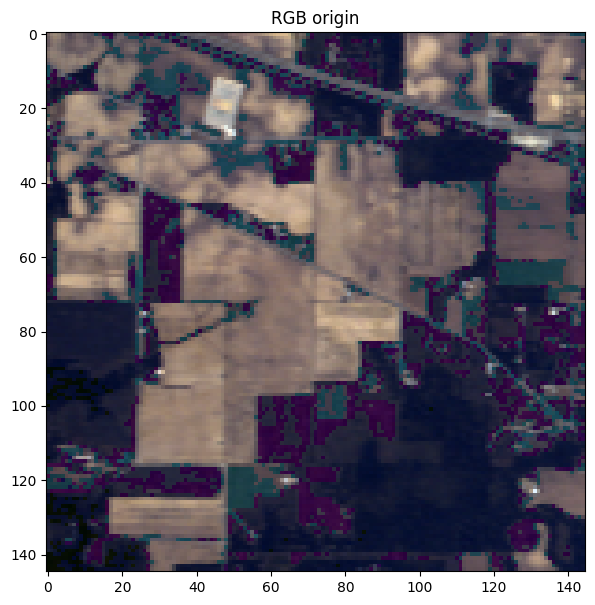

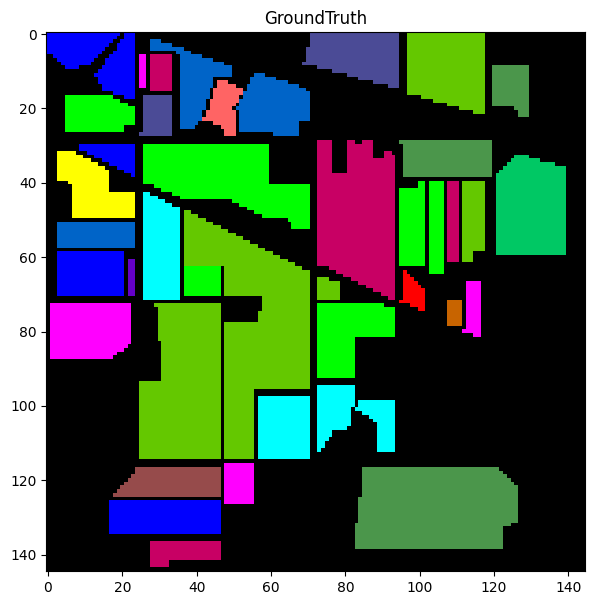

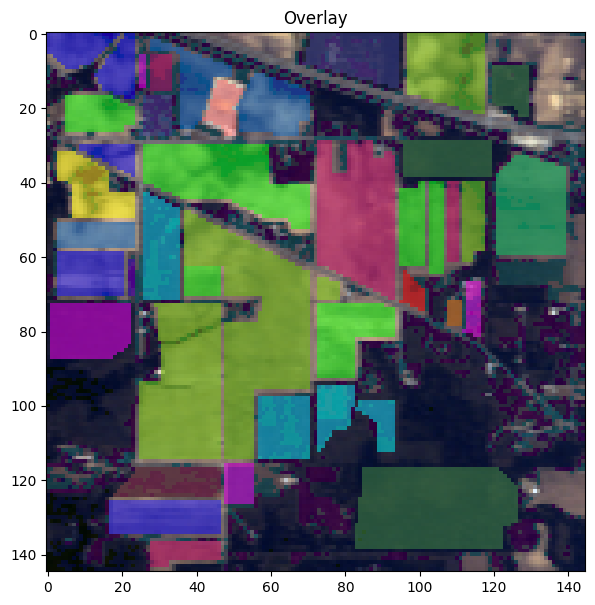

In [8]:
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'./_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'./_gt.jpg',label,colors = spectral.spy_colors)

In [9]:
pca_components = pca_components if dataset == 'IP' else 15
X, pca = applyPCA(data, numComponents=pca_components)
y = label
X.shape

(145, 145, 30)

In [10]:
X,y = createImageCubes(X, y, patch_size=patch_size)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=test_ratio,
                                                random_state=42,
                                                stratify=y)

### 展示数据集采样信息

In [12]:
sample_report = f"{'class': ^10}{'train_num':^10}{'test_num': ^10}{'all_num':^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{i: ^10}{(ytrain==i).sum(): ^10}{(ytest==i).sum(): ^10}{(y==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(ytrain): ^10}{np.count_nonzero(ytest): ^10}{np.count_nonzero(y): ^10}"
print(sample_report)

  class   train_num  test_num  all_num  
    1        428       1000      1428   
    2        249       581       830    
    3         71       166       237    
    4        145       338       483    
    5        219       511       730    
    6         8         20        28    
    7        143       335       478    
    8         6         14        20    
    9        292       680       972    
    10       736       1719      2455   
    11       178       415       593    
    12        62       143       205    
    13       379       886       1265   
    14       116       270       386    
    15        28        65        93    
    16        0         0         0     
  total      3060      7143     10203   


## 构建模型

c:\Users\Sendfor\PyWORKSPACE\stu_torch\venv\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


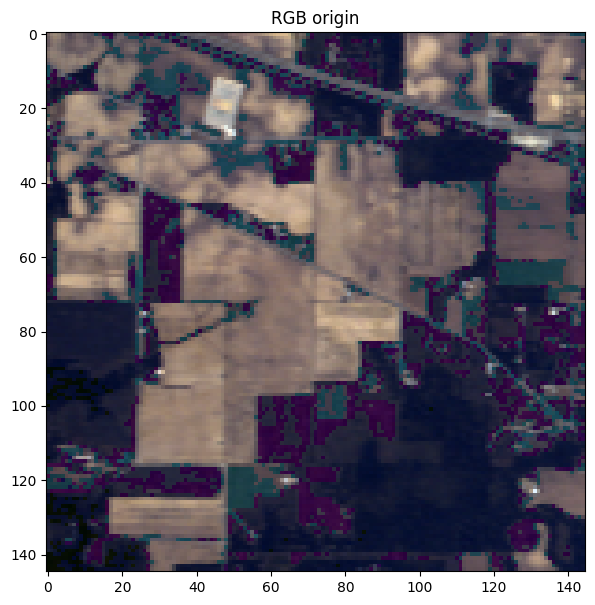

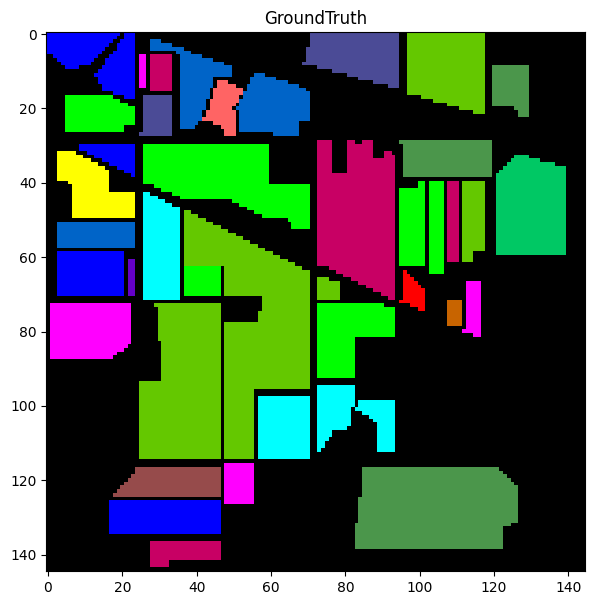

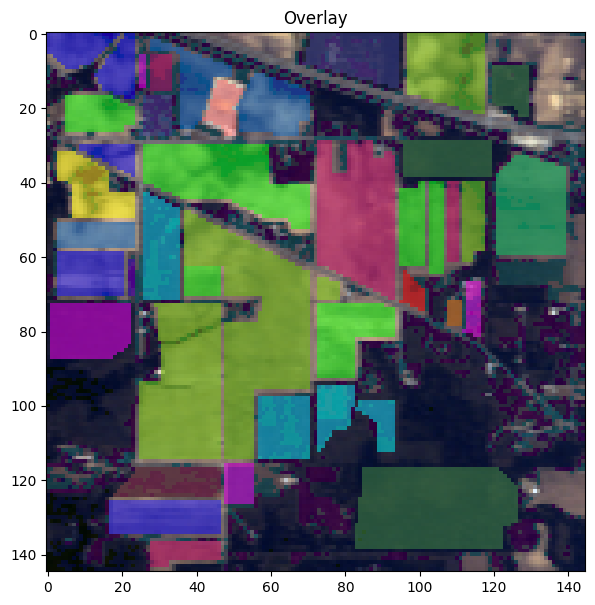

In [13]:
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'./_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'./_gt.jpg',label,colors = spectral.spy_colors)

In [14]:
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out


### 测试网络是否跑通

In [15]:
module = HybridSN(in_chs=pca_components, patch_size=patch_size, class_nums=class_nums)
input = torch.zeros((1, 30, 25, 25))
output = module(input)
print(output.shape)

torch.Size([1, 16])


### 查看网络构造

In [16]:
summary(module, input_size=(1,30,25,25),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

Layer (type (var_name))                  Param #    Kernel Shape Mult-Adds  Input Shape Output Shape
HybridSN (HybridSN)                      --         --         --         [1, 30, 25, 25] [1, 16]
├─Sequential (conv1)                     --         --         --         [1, 1, 30, 25, 25] [1, 8, 24, 23, 23]
│    └─Conv3d (0)                        512        [7, 3, 3]  6,500,352  [1, 1, 30, 25, 25] [1, 8, 24, 23, 23]
│    └─ReLU (1)                          --         --         --         [1, 8, 24, 23, 23] [1, 8, 24, 23, 23]
├─Sequential (conv2)                     --         --         --         [1, 8, 24, 23, 23] [1, 16, 20, 21, 21]
│    └─Conv3d (0)                        5,776      [5, 3, 3]  50,944,320 [1, 8, 24, 23, 23] [1, 16, 20, 21, 21]
│    └─ReLU (1)                          --         --         --         [1, 16, 20, 21, 21] [1, 16, 20, 21, 21]
├─Sequential (conv3)                     --         --         --         [1, 16, 20, 21, 21] [1, 32, 18, 19, 19]
│    └─Conv

## 迭代数据

In [17]:
# 转换数据以适应 pytorch 结构
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components)
Xtrain = Xtrain.transpose(0, 3, 1, 2)
Xtest  = Xtest.transpose(0, 3, 1, 2)
Xtrain.shape,Xtest.shape

((3074, 30, 25, 25), (7175, 30, 25, 25))

### 创建可以迭代的训练集和测试集类

In [18]:
class TrainDataset(Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.X_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [19]:
class TestDataset(Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.X_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

### 构造Dataloader

In [20]:
TrainDataset = TrainDataset()
TestDataset = TestDataset()

batch_size = 128

# 按理如果是windows平台只有设置为num_workers=0才不报错，但是移动到kaggle或者colab训练时，所使用在平台就是linux
# 所以以下判断语句不适合有cuda的windows平台
if torch.cuda.is_available():
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
else:
    nw = 0 

train_loader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False, num_workers=nw)

## 训练模型并绘制曲线

100%|██████████| 57/57 [00:21<00:00,  2.68it/s]
[epoch 5] train_loss: 2.03740  val_accuracy: 0.41756
100%|██████████| 57/57 [00:20<00:00,  2.84it/s]
[epoch 10] train_loss: 0.35581  val_accuracy: 0.94174
100%|██████████| 57/57 [00:19<00:00,  2.91it/s]
[epoch 15] train_loss: 0.12988  val_accuracy: 0.98160
100%|██████████| 57/57 [00:20<00:00,  2.84it/s]
[epoch 20] train_loss: 0.07818  val_accuracy: 0.98913
100%|██████████| 57/57 [00:19<00:00,  2.91it/s]
[epoch 25] train_loss: 0.04260  val_accuracy: 0.99415
100%|██████████| 57/57 [00:20<00:00,  2.78it/s]
[epoch 30] train_loss: 0.03762  val_accuracy: 0.99289
100%|██████████| 57/57 [00:21<00:00,  2.69it/s]
[epoch 35] train_loss: 0.02097  val_accuracy: 0.99582
100%|██████████| 57/57 [00:21<00:00,  2.66it/s]
[epoch 40] train_loss: 0.02173  val_accuracy: 0.99540
100%|██████████| 57/57 [00:20<00:00,  2.76it/s]
[epoch 45] train_loss: 0.01544  val_accuracy: 0.99443
100%|██████████| 57/57 [00:19<00:00,  2.88it/s]
[epoch 50] train_loss: 0.01920  val

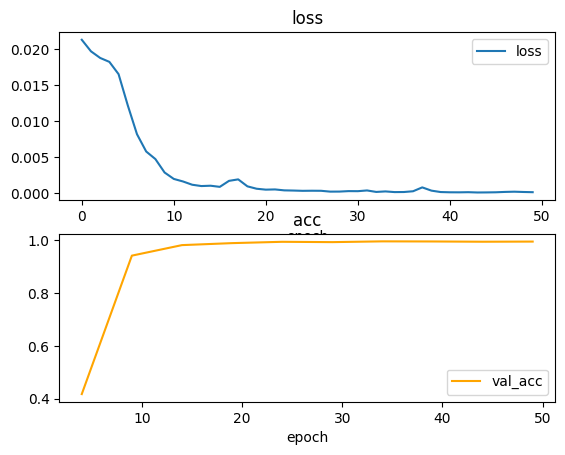

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_name = 'HybridSN'
net = HybridSN(in_chs=pca_components, patch_size=patch_size, class_nums=class_nums)
net.to(device=device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_list = []
val_acc_list = []
val_epoch_list = []

epochs = 50
best_acc = 0.0
save_path = './{}Net.pth'.format(model_name)
train_steps = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = test_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)

    for batch_idx, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_bar.desc = 'train epoch[{}/{}] loss:{:.5f}'.format(epoch+1, epochs, loss)
    loss_list.append(running_loss/train_num)

    # validate,after train 5 times 
    if (epoch+1)%5==0 or (epoch+1)==epochs:
        acc = 0.0 # accumulate accurate number / epoch
        net.eval()
        with torch.no_grad():
            val_bar = tqdm(test_loader, file=sys.stdout)

            for batch_idx, (val_inputs, val_labels) in enumerate(val_bar):
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                outputs = net(val_inputs)
                predict_y = torch.max(outputs, dim=1)[1] # [1]我们只需要知道最大值所在的位置在哪里，也就是索引
                acc += torch.eq(predict_y, val_labels).sum().item()

        val_accurate = acc / val_num
        val_acc_list.append(val_accurate)
        val_epoch_list.append(epoch)
        print('[epoch %d] train_loss: %.5f  val_accuracy: %.5f' %
                (epoch + 1, running_loss / train_steps, val_accurate))
        
        # get best model
        if val_accurate > best_acc:
                best_acc = val_accurate
                torch.save(net.state_dict(), save_path)

ax1.plot(np.arange(epoch+1), loss_list, label='loss')
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax1.legend()

ax2.plot(val_epoch_list, val_acc_list, label = 'val_acc', c='orange')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

print('Finished Training')

## 载入模型验证

### 生成分类报告

In [22]:
model = HybridSN(in_chs=pca_components, patch_size=patch_size, class_nums=class_nums).to(device=device)
weights_path = save_path
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path, map_location=device))

model.eval()
y_pred_test = []
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    predicted = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    y_pred_test.append(predicted)

y_pred_test = np.concatenate(y_pred_test)

classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    0.9688    0.9841        32
         1.0     0.9990    0.9990    0.9990      1000
         2.0     0.9897    0.9948    0.9923       581
         3.0     1.0000    1.0000    1.0000       166
         4.0     0.9970    0.9911    0.9941       338
         5.0     0.9961    0.9961    0.9961       511
         6.0     1.0000    0.9500    0.9744        20
         7.0     1.0000    0.9970    0.9985       335
         8.0     1.0000    1.0000    1.0000        14
         9.0     0.9941    0.9985    0.9963       680
        10.0     0.9977    0.9983    0.9980      1719
        11.0     0.9855    0.9855    0.9855       415
        12.0     1.0000    1.0000    1.0000       143
        13.0     0.9944    1.0000    0.9972       886
        14.0     0.9963    0.9926    0.9944       270
        15.0     1.0000    0.9077    0.9516        65

    accuracy                         0.9958      7175
   macro avg     0.9969   

In [23]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [24]:
def reports (test_loader,y_test,name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred = outputs
            count = 1
        else:
            y_pred = np.concatenate((y_pred, outputs))

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

In [25]:
classification, confusion, oa, each_acc, aa, kappa = reports(test_loader, ytest, dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

In [26]:
with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [27]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [28]:
# load the original image
X, y = loadData(dataset)

In [29]:
height = y.shape[0]
width = y.shape[1]
patch_size = patch_size
numComponents = pca_components

In [30]:
pca_components = pca_components if dataset == 'IP' else 15
X, pca = applyPCA(data, numComponents=pca_components)
X.shape

(145, 145, 30)

In [31]:
X = padWithZeros(X, patch_size//2)
X.shape

(169, 169, 30)

C:\Users\Sendfor\AppData\Local\Temp\ipykernel_23400\1225206175.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction+1


... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


c:\Users\Sendfor\PyWORKSPACE\stu_torch\venv\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


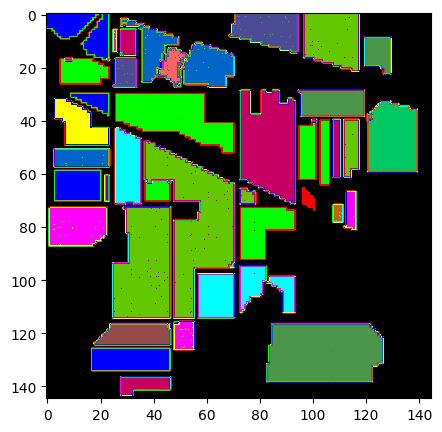

In [32]:
#逐像素预测图像类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(-1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2])
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 3, 1, 2)).to(device)
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

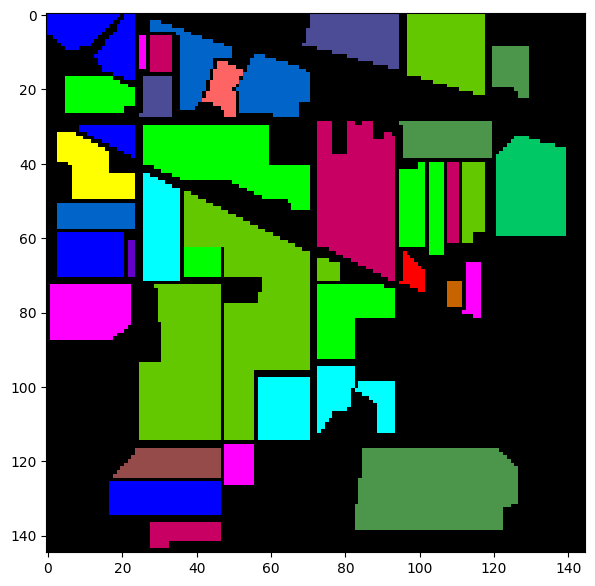

In [33]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

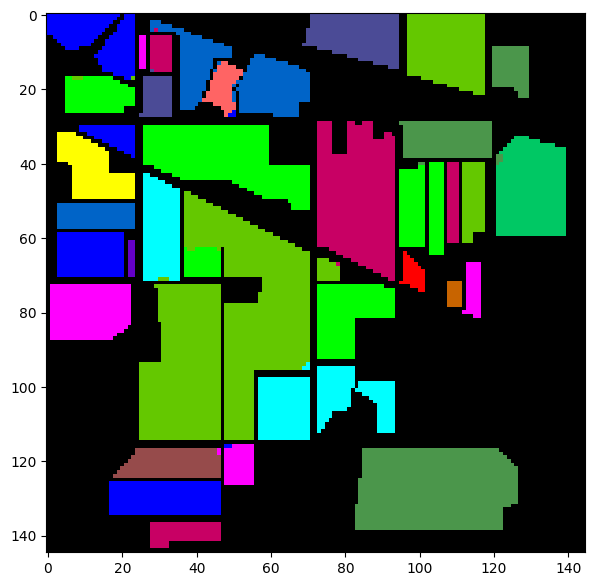

In [34]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

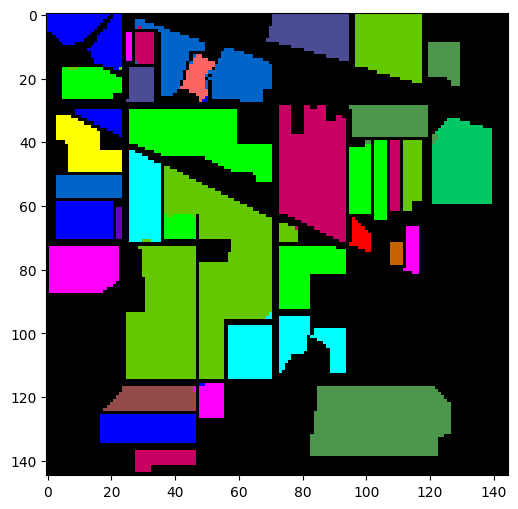

In [35]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(6,6))

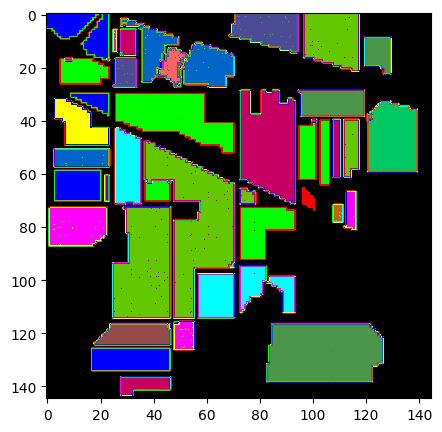

In [36]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

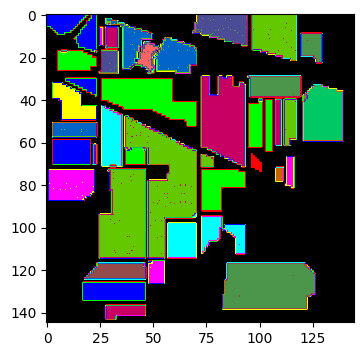

In [37]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(4,4))